In [1]:
# Script pour manipuler un tirage et comparer des colonnes

In [2]:
# -*- coding: utf8 -*-
import pandas as pd
import pickle, glob,re
import itertools as it
import networkx as nx
import numpy as np
import matplotlib as plt

In [3]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/gilles/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
phonologicalMap="-S"

In [5]:
def tiragesNom(nom):
    result=[tirage for tirage in listeTirages if "-"+nom in tirage]
    return result

def tiragesNomMorphomes(nom):
    result=[tirage for tirage in listeTiragesMorphomes if "-"+nom in tirage]
    return result
    
baseRepName="/Users/gilles/Box Sync/2015-Data/"
repName=baseRepName+"DerivationParadigmes/"
longNames=[n for n in glob.glob(repName+"*.pkl") if not "Morphome" in n]
    
listeTirages=glob.glob("/Users/gilles/Box Sync/2015-Data/*-Tirage.pkl")
listeTirages200Mo=tiragesNom("200Mo")
listeTirages20=tiragesNom("20Mo")
listeTirages1=tiragesNom("1Mo")
listeTirages50k=tiragesNom("50Ko")
listeTirages100k=tiragesNom("100Ko")
listeTirages20000k=tiragesNom("20000Ko")
listeTiragesMorphomes=glob.glob("/Users/gilles/Box Sync/2015-Data/*-Tirage-*Morphomes.pkl")
listeTiragesMorphomes200Mo=tiragesNomMorphomes("200Mo")
listeTiragesMorphomes20=tiragesNomMorphomes("20Mo")
listeTiragesMorphomes1=tiragesNomMorphomes("1Mo")
listeTiragesMorphomes50k=tiragesNomMorphomes("50Ko")
listeTiragesMorphomes100k=tiragesNomMorphomes("100Ko")
listeTiragesMorphomes20000k=tiragesNomMorphomes("20000Ko")
listeTiragesMorphomes200Mo

[]

In [6]:
def lireLexique(nomLexique):
    try:
        with open(nomLexique, 'rb') as input:
            lexique=pickle.load(input)
    except:
        lexique=None
    return lexique

In [ ]:
nomLexique=longNames[0]
lexique=lireLexique(nomLexique)
lexique1=lexique[lexique["tir1"]>0]
taille=lexique[lexique["tir1"]>0]["tir1"].count()
paradigmes=pd.pivot_table(lexique[lexique["tir1"]>0], values='phono', index=['lexeme'], columns=['case'], aggfunc=lambda x: ",".join(x)).reset_index().reindex()


In [ ]:
def compPaire(c1,c2):
    syncretisms=[]
    c1Val=paradigmes[c1].notnull()
    c2Val=paradigmes[c2].notnull()
    c1Sur=paradigmes[c1].str.contains(",")
    c2Sur=paradigmes[c2].str.contains(",")
    l1=len(paradigmes[paradigmes[c1].notnull()])
    l2=len(paradigmes[paradigmes[c2].notnull()])
    paire=paradigmes[c1Val & c2Val & (paradigmes[c1]!=paradigmes[c2])][[c1,c2]]
    lenDiff=len(paire[~paire[c1].str.contains(",") & ~paire[c2].str.contains(",")])
    if lenDiff>0:
        if debug:
            print u"%s ≠ %s"%(c1,c2)
            print "différence",lenDiff
            if lenDiff<12:
                print paire
    else:
        surAbondant=paire[paire[c1].str.contains(",") | paire[c2].str.contains(",")]
#            print "--------------------------------"
        if len(surAbondant)==0:
#                print u"%s = %s"%(c1,c2) 
            syncretisms.append(u"%s = %s"%(c1,c2))
        else:
            compatible=True
            for index,row in surAbondant.iterrows():
                if "," in row[c1]:
                    if "," in row[c2]:
                        if row[c1]!=row[c2]:
                            compatible=False
                    else:
                        if not row[c2] in row[c1].split(","):
                            compatible=False
                else:
                    if not row[c1] in row[c2].split(","):
                        compatible=False
            if compatible:
#                    print u"%s = %s"%(c1,c2)
                syncretisms.append(u"%s = %s"%(c1,c2))
            else:
                print u"%s ≠ %s"%(c1,c2)
                print surAbondant

In [ ]:
def assignerTNS(row):
    if row[-2:] in [p+n for p in ["1","2","3"] for n in ["S","P"]]:
        return row[:2]
    else:
        return "NF"

def assignerPER(row):
    if row[-2:] in [p+n for n in ["S","P"] for p in ["1","2","3"] ]:
        return row[-2:]
    else:
        if row=="inf":
            return "1S"
        elif row=="pP":
            return "2S"
        elif row=="ppMS":
            return "3S"
        elif row=="ppMP":
            return "1P"
        elif row=="ppFS":
            return "2P"
        elif row=="ppFP":
            return "3P"

lexique["TNS"]=lexique["case"].apply(assignerTNS)
lexique["PER"]=lexique["case"].apply(assignerPER)

In [ ]:
lexeme=u"être"
tableauTest=lexique[lexique["lexeme"]==lexeme].pivot_table(values='phono', index=['lexeme','TNS'], columns=["PER"], aggfunc=lambda x: ",".join(x))
tableauTest

In [ ]:
ligTable=['pi', 'ii', 'fi','pc','ps','ai','is','pI','NF']
colTable=[p+n for n in ["S","P"] for p in ["1","2","3"] ]
colTuple=[("PER",col) for col in colTable]
ligTuple=[("TNS",lig) for lig in ligTable]

In [ ]:
tableauTest=tableauTest.reindex(columns=colTable)

In [ ]:
idxTableau = tableauTest.sortlevel(level='TNS').index
idxTableau=[idxTableau[i] for i in [7, 3, 2, 6, 1,4,5,0]]
tableauTest=tableauTest.reindex(idxTableau)
print tableauTest.to_latex().replace("None","")

# Nombre de formes différentes par taille d'échantillon

In [63]:
unsPoints=[]
for tirage in longNames:
    lexique=lireLexique(tirage)
    tirs=lexique[lexique["tir1"]>0]["tir1"].sum()
    taille=lexique[lexique["tir1"]>0]["tir1"].count()
    unsPoints.append((tirs, taille)) 

In [64]:
autresPoints=[(1000000,43563),
              (2000000,52654),
              (3000000,57648),
              (4000000,60647),
              (5000000,62926),
              (6000000,64507),
              (7000000,65694),
              (8000000,66597),
              (9000000,67395),
              (10000000,68049),
              (11000000,68590),
              (12000000,69007),
              (13000000,69382),
              (14000000,69690),
              (15000000,69959),
              (16000000,70178),
              (17000000,70379),
              (18000000,70547),
              (19000000,70704),
              (20000000,70859),  
              (200000000,74702),
              (400000000,76076),
              (600000000,77351),
              (800000000,78517),
              (1000000000,79565),
              (1200000000,80618),
              (1400000000,81578),
              (1600000000,82505),
             ]
points=unsPoints

In [65]:
pdPoints=pd.DataFrame(points)
pdPoints.columns=["Sample Size", "Number of Forms"]
pdPoints.set_index("Sample Size",inplace=True)
xPoints=list(pdPoints.index)
pdPoints

,Number of Forms
Sample Size,
1000,677
2000,1193
3000,1642
4000,2060
5000,2447
6000,2805
7000,3152
8000,3464
9000,3781


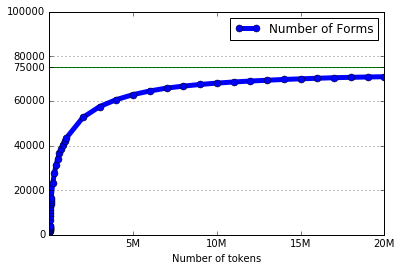

In [67]:
#pdPoints.plot(ylim=(0,300000))
ax=pdPoints.plot(linewidth=5,marker="o",markersize=7,xlim=(0,20e6),ylim=(0,1e5))
ax.set(xlabel="Number of tokens")
ax.set_figsize=(5,20)
ax.set_xticks([5000000,10000000,15000000,20000000])
ax.set_xticklabels(["5M","10M","15M","20M"])
ax.axhline(y=75000, color='g', linestyle='-')
ax.yaxis.grid(True, which='major')
yticks=ax.get_yticks().tolist()
yticks.append(75000.0)
yticks=sorted(yticks)
ax.set_yticks(np.array(yticks))
plt.savefig(repName+"NbForms.png", format='png', dpi=300)

# Nombre moyen de formes par lexème

In [69]:
nbMoyenFormesPoints=[]
for tirage in longNames:
    lexique=lireLexique(tirage)
    nbTokens=lexique[lexique["tir1"]>0]["tir1"].sum()
    pdTirsCases=lexique.groupby(by=["lexeme","case"])[["tir1"]].sum()
    pdTirsCases.reset_index(inplace=True)
    pdDist=pdTirsCases.groupby(by="lexeme")[["case","tir1"]].count()
    nbMoyenFormes=pdDist["case"].mean()
    nbMoyenFormesPoints.append((nbTokens, nbMoyenFormes)) 

In [70]:
pdPoints=pd.DataFrame(nbMoyenFormesPoints)
pdPoints.columns=["Sample Size", "Average number of co-forms"]
pdPoints.set_index("Sample Size",inplace=True)
xPoints=list(pdPoints.index)
pdPoints

,Average number of co-forms
Sample Size,
1000,1.810160
2000,2.074783
3000,2.254121
4000,2.419506
5000,2.574737
6000,2.693564
7000,2.803381
8000,2.889816
9000,2.973249


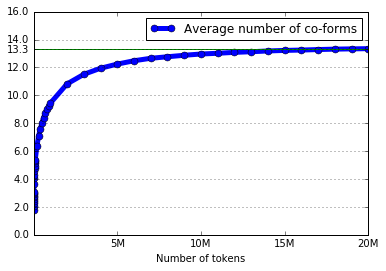

In [83]:
#pdPoints.plot(ylim=(0,300000))
ax=pdPoints.plot(linewidth=5,marker="o",markersize=7,xlim=(0,20e6),ylim=(0,16))
ax.set(xlabel="Number of tokens")
ax.set_xticks([5000000,10000000,15000000,20000000])
ax.set_xticklabels(["5M","10M","15M","20M"])
ax.axhline(y=13.3, color='g', linestyle='-')
ax.yaxis.grid(True, which='major')
yticks=ax.get_yticks().tolist()
yticks.append(13.3)
yticks=sorted(yticks)
ax.set_yticks(np.array(yticks))
plt.savefig(repName+"MeanNbForms.png", format='png', dpi=300)

# Nombre de lexèmes par nombre de formes

In [11]:
def getTokensForms(nomFichier):
    m=re.search(ur"-T(\d+)-",nomFichier)
    if m:
        nbTokens=int(m.group(1))
    else:
        print "pas de nombre de Tokens dans le nom de fichier"
        nbTokens=pd.NaT
    m=re.search(ur"-F(\d+)-",nomFichier)
    if m:
        nbForms=int(m.group(1))
    else:
        print "pas de nombre de Tokens dans le nom de fichier"
        nbForms=pd.NaT
    return [nbTokens,nbForms]

In [35]:
def getCoformsDistribution(lexique):
    pdTirsCases=lexique.groupby(by=["lexeme","case"])[["tir1"]].sum()
    pdTirsCases.reset_index(inplace=True)
    pdDist=pdTirsCases.groupby(by="lexeme")[["case","tir1"]].count()
    print pdDist["case"].mean()
    pdDist.reset_index(inplace=True)
    return pdDist.groupby(by="case")[["lexeme"]].count()

In [21]:
longNames

['/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-00-T1000-F677-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-01-T2000-F1193-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-02-T3000-F1642-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-03-T4000-F2060-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-04-T5000-F2447-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-05-T6000-F2805-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-06-T7000-F3152-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-07-T8000-F3464-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-08-T9000-F3781-170701-1050.pkl',
 '/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-09-T10000-F408

In [79]:
numLongName=27
longNames[numLongName]

'/Users/gilles/Box Sync/2015-Data/DerivationParadigmes/Longitudinal-27-T1000000-F43314-170701-1050.pkl'

9.4334932403


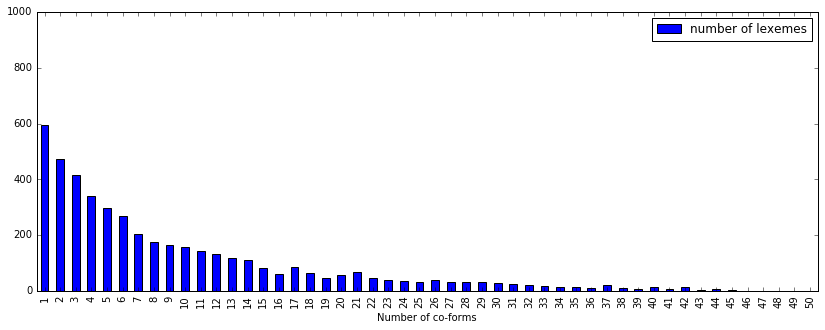

In [80]:
nbTokens,nbForms=getTokensForms(longNames[numLongName])
lexique=lireLexique(longNames[numLongName])
df=getCoformsDistribution(lexique)
df=df.reindex(range(df.index[0],df.index[-1]+1))
df.columns=["number of lexemes"]
df.fillna(0.0)
#ax=df.plot(kind="bar",figsize=(14,5),legend=False,ylim=(0,1000))
#ax.set(xlabel="Number of co-forms",ylabel="Number of lexemes")
ax=df.plot(kind="bar",figsize=(14,5),legend=True,ylim=(0,1000))
ax.set(xlabel="Number of co-forms")
plt.savefig(repName+"DistNbCoforms%d.png"%nbTokens, format='png', dpi=300)

# Nombre de lexèmes par nombre de formes par taille d'échantillon
- nom du fichier échantillon => tirage
- tirage de l'échantillon => lexique
- formes tirées de l'échantillon => lexique1
- cases tirées de l'échantillon => nbCases
- nombre de token dans le tirage =>nbTokens
- distribution du nombre de lexème par nombre de forme => distNbFormes
- liste des distributions => distributions


In [ ]:
lexiquePrefix="MGC-160104"

with open("/Users/gilles/Box Sync/2015-Data/MGC-Vienna/"+lexiquePrefix+'-Verbes2-NbForms.pkl', 'rb') as input:
    dictNbFormes = pickle.load(input)
with open("/Users/gilles/Box Sync/2015-Data/MGC-Vienna/"+lexiquePrefix+'-Verbes2%s-Morphomes-NbForms.pkl'%phonologicalMap, 'rb') as input:
    dictNbFormesMorphomiques = pickle.load(input)

In [ ]:
def nbMax(row):
    
    if brut:
        dictNb=dictNbFormes
    else:
        dictNb=dictNbFormesMorphomiques
        
    if dictNb[row["lexeme"]]==row["Number of Forms"]:
        return True
    else:
        return False

def nbFull(row):
    
    if brut:
        dictNb=dictNbFormes
        if dictNb[row["lexeme"]]==row["Number of Forms"] and row["Number of Forms"] in listeNbCasesMax:
            return True
        else:
            return False
    else:
        dictNb=dictNbFormesMorphomiques
        lexMax=dictNb[row["lexeme"]]
        if lexMax==31:
            if row["Number of Forms"]==min(listeNbCasesMax):
                return True
            elif row["Number of Forms"]>min(listeNbCasesMax):
                print row["lexeme"],"pb avec le nb de formes",row["Number of Forms"],"lexMax =",lexMax
                return False
            else:
                return False
        elif lexMax==32:
            if row["Number of Forms"]==max(listeNbCasesMax):
                return True
            elif row["Number of Forms"]>max(listeNbCasesMax):
                print row["lexeme"],"pb avec le nb de formes",row["Number of Forms"],"lexMax =",lexMax
                return False
            else:
                return False
        else:
            return False

In [ ]:
distributions=[]
brut=False
for nTirage,tirage in enumerate(listeTiragesMorphomes20000k):
#    print tirage
    lexique=lireLexique(tirage)
    if isinstance(lexique, pd.DataFrame):
        lexique1=lexique[lexique["tir1"]>0]
        nbTokens=lexique1["tir1"].sum()
        nbCases=lexique1.groupby(by=["lexeme","case"],as_index=False).agg({"tir1":sum})
        listeMorphomes=lexique1.groupby(["case"],as_index=False)["lexeme"].count()["case"].tolist()
        nbMorphomes=len(listeMorphomes)
        listeMorphomesNoPP=[m for m in listeMorphomes if not "pp" in m]
        nbMorphomesOnePP=len(listeMorphomesNoPP)+1
        listeNbCasesMax=[nbMorphomesOnePP,nbMorphomes]
        print listeNbCasesMax
        nbFormes=nbCases.groupby(by=["lexeme"])[["case"]].count()
#        nbFormes=lexique1.groupby(by=["lexeme"])[["phono"]].count()
        nbFormes.columns=["Number of Forms"]
        distNbFormes=nbFormes.groupby(by=["Number of Forms"])[["Number of Forms"]].count()
        distNbFormes.columns=["Number of lexemes"]
        nbFormes.reset_index(inplace=True)
        lexemesMax=nbFormes[nbFormes.apply(nbMax,axis=1)]
        lexemesFull=nbFormes[nbFormes.apply(nbFull,axis=1)]
        distributions.append((nbTokens, distNbFormes,lexemesMax,lexemesFull))
        print tirage
        print "{:,}".format(nbTokens)
        print len(lexemesFull)
        print lexemesFull
        print distNbFormes[30:]
#        print lexemesMax
        print
        print
        if nTirage%1==0 and True:
            distNbFormes.plot(kind="bar",figsize=(20,10),ylim=(0,1000))

In [ ]:
#nbCases[nbCases["lexeme"]=="faire"]
#lexique[lexique["lexeme"]=="faire"]
listeMorphomes=lexique1.groupby(["case"],as_index=False)["lexeme"].count()["case"].tolist()
nbMorphomes=len(listeMorphomes)
listeMorphomesNoPP=[m for m in listeMorphomes if not "pp" in m]
nbMorphomesOnePP=len(listeMorphomesNoPP)+1

In [ ]:
    
nbFormes.reset_index(inplace=True)
nbFormes[nbFormes.apply(nbMax,axis=1)]

# Calculs sur les tirages de 200Mo cumulés

In [ ]:
listeLexiques=listeTirages200
cumulLexique=lireLexique(listeLexiques[0])
cumulLexique["tir1"]=0
for nTirage,tirage in enumerate(listeLexiques):
#    print nTirage,
    lexique=lireLexique(tirage)
    cumulLexique["tir1"]=cumulLexique["tir1"]+lexique["tir1"]
    lexique1=cumulLexique[cumulLexique["tir1"]>0]
    nbTokens=lexique1["tir1"].sum()
    nbTypes=lexique1["tir1"].count()
    print "(%d,%d),"%(nbTokens,nbTypes)
    nbCases=lexique1.groupby(by=["lexeme","case"],as_index=False).agg({"tir1":sum})
    nbFormes=nbCases.groupby(by=["lexeme"])[["case"]].count()
    nbFormes.columns=["Number of Forms"]
    distNbFormes=nbFormes.groupby(by=["Number of Forms"])[["Number of Forms"]].count()
    distNbFormes.columns=["Number of lexemes"]
    distributions.append(distNbFormes)
    if nTirage%1==5:
        distNbFormes.plot(kind="bar",figsize=(20,10),ylim=(0,1000))    

In [ ]:
for n in [int(1e6*k) for k in range(1,1600)]:
    if not n in pdPoints.index:
        pdPoints.loc[n]=np.NaN
pdPoints.sort_index(inplace=True)
pdPoints.interpolate(method="slinear", order=4, inplace=True)
derivativeNb=pdPoints.diff().reset_index()
derivativeNb.set_index("Sample Size",inplace=True)

In [ ]:
funcDerivativeNb=derivativeNb[derivativeNb["Sample Size"].isin(xPoints)]
funcDerivativeNb.set_index("Sample Size",inplace=True)

In [ ]:
funcDerivativeNb.ix["150000000":].plot()

In [ ]:
funcDerivativeNb

In [ ]:
for tirage in listeTirages:
    lexique=lireLexique(tirage)
    if isinstance(lexique, pd.DataFrame):
        lexique1=lexique[lexique["tir1"]>0]
        tokens=lexique[lexique["tir1"]>0]["tir1"].sum()
        print tokens,tirage
        print


In [ ]:
lexique1.groupby(by=["lexeme"]).count()

# Surabondance dans le lexique complet

In [ ]:
with open("/Users/gilles/Box Sync/2015-Data/MGC-160104-Verbes2.pkl", 'rb') as input:
    lexiqueComplet = pickle.load(input)

In [97]:
pdSurabondance=lexiqueComplet.groupby(by=["lexeme","case"])[["ortho"]].count()

In [98]:
pdSurabondance.reset_index(inplace=True)

In [101]:
pdSurabondance[pdSurabondance["ortho"]>1].count()

lexeme    845
case      845
ortho     845
dtype: int64

In [103]:
lexiqueComplet.groupby(by="lexeme").count()

,ortho,phono,ext,cs,ms,vs,freq,prob,case
lexeme,,,,,,,,,
abaisser,51,51,45,51,51,51,51,51,51
abandonner,51,51,45,51,51,51,51,51,51
abasourdir,51,51,46,51,51,51,51,51,51
abattre,51,51,47,51,51,51,51,51,51
abcéder,48,48,43,48,48,48,48,48,48
abdiquer,51,51,45,51,51,51,51,51,51
abecquer,51,51,45,51,51,51,51,51,51
aberrer,48,48,43,48,48,48,48,48,48
abhorrer,51,51,45,51,51,51,51,51,51


In [104]:
lexiqueComplet.count()

ortho     328103
phono     328103
ext       287320
cs        328103
ms        328103
vs        328103
lexeme    328103
freq      328103
prob      328103
case      328103
dtype: int64